## Understanding the model

<i>Note: This notebook has not been part of our regular group work but rather came about during debugging and trying to understand why our model behaves in that specific way. It has lead to some extra slides in case of more detailed questions about our model. As the findings give some insight into the workings of our model, they are included here. Furthermore, it shows how important it is to carefully consider which aspects to put into a model.</i>



In [ ]:
# library imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import import_ipynb
import pickle
from itertools import product
from functools import partial


In [ ]:
# local imports
from input_output import load_data, save_data
from analysis import check_probability_conserved

importing Jupyter notebook from input_output.ipynb
importing Jupyter notebook from analysis.ipynb
importing Jupyter notebook from rk4.ipynb
importing Jupyter notebook from awareness.ipynb


In [ ]:

def monte_carlo_1D(f, y0, t, params, n):
    ytn = np.zeros(shape=(*y0.shape, len(t), n))
    for i in range(n):
        print('\r', i, i/n, end='')
        ytn[..., i] = f(y0, t, params)
    yt = np.average(ytn, axis=-1)  # use average for picture but plot median for time series
    print('\r' + '                ' + '\r')
    return yt, ytn

In [ ]:

def superpos_grid_sim_1D(y0, t, params, one_direction_only=False):
    beta, gamma = params
    left = np.s_[:-1]  # everything except the last column
    right = np.s_[1:]  # everything except the first column

    origin = [left, right]  # to be iterated over
    destination = [right, left]  # "opposite" to origin, order must "match" origin

    if one_direction_only:
        origin = origin[::2]
        destination = destination[::2]

    yt = np.zeros(shape=(*y0.shape, len(t)))
    yt[..., 0] = y0

    for i in range(len(t)-1):
        dy = np.zeros(shape=y0.shape)
        y = yt[..., i]
        dt = t[i+1]-t[i]
        # infection transmission
        for source, target in zip(origin, destination):  # iterating over the 4 neighbor cells
            # for each element in origin and its corresponding element in destination
            nt = y[target][..., 0]
            ns = y[source][..., 1]
            dy[target][..., 1] += beta*dt * nt * ns
            dy[target][..., 0] -= beta*dt * nt * ns

        # recovery
        I = y[..., 1]  # infections
        dy[..., 1] -= gamma*dt * I  # removing infections from the infected compartment
        dy[..., 2] += gamma*dt * I  # and adding them to the recovered compartment

        yt[..., i+1] = yt[..., i] + dy
    return yt

In [ ]:

def monte_carlo_grid_single_pass_1D(y0, t, params, one_direction_only=False):
    beta, gamma = params
    left = np.s_[:-1]  # everything except the last column
    right = np.s_[1:]  # everything except the first column

    origin = [left, right]  # to be iterated over
    destination = [right, left]  # "opposite" to origin, order must "match" origin

    yt = np.zeros(shape=(*y0.shape, len(t)))
    yt[..., 0] = y0

    if one_direction_only:
        origin = origin[::2]
        destination = destination[::2]

    for i in range(len(t)-1):
        dy = np.zeros(shape=y0.shape)
        y = yt[..., i]
        dt = t[i+1]-t[i]

        # infection transmission
        for source, target in zip(origin, destination):  # iterating over the 4 neighbor cells
            # for each element in origin and its corresponding element in destination
            nt = y[target][..., 0]
            ns = y[source][..., 1]
            rnd = np.random.random(size=nt.shape)
            p = np.where(rnd < beta*dt, 1, 0)
            dy[target][..., 1] += p * nt * ns
            dy[target][..., 0] -= p * nt * ns

        # recovery
        I = y[..., 1]  # infections
        rnd = np.random.random(size=I.shape)
        p = np.where(rnd < gamma*dt, 1, 0)
        dy[..., 1] -= p * I  # removing infections from the infected compartment
        dy[..., 2] += p * I  # and adding them to the recovered compartment

        dy = np.where(dy >= 1, 1, np.where(dy <= -1, -1, 0))  # remove double infections etc.

        yt[..., i+1] = yt[..., i] + dy
    return yt

In [ ]:
def movement_speed_1D(beta, gamma, title, fname):

    params = (beta, gamma)

    t = np.linspace(0, 1000, 1001)

    y0 = np.zeros(shape=(200, 3))
    y0[:, 0] = 1
    y0[0, 1] = 1
    y0[0, 0] = 0
    x = np.array(range(y0.shape[0]))

    n = 100

    yt_superpos = superpos_grid_sim_1D(y0, t, params)
    yt_superpos_one_direction = superpos_grid_sim_1D(y0, t, params, one_direction_only=True)
    yt_montecarlo, ytn_montecarlo = monte_carlo_1D(monte_carlo_grid_single_pass_1D, y0, t, params, n)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    for k in range(5):
        kk = k*250
        ls = ['-', '-.', '--', ':', '-']
        ax.plot(x, yt_superpos[..., 1, kk], color='tab:blue', linestyle=ls[k], label='superpos')
        ax.plot(x, yt_superpos_one_direction[..., 1, kk], color='tab:cyan', linestyle=ls[k], label='superpos\none direction only')
        ax.plot(x, yt_montecarlo[..., 1, kk], color='tab:purple', linestyle=ls[k], label='monte carlo')
        #[ax.plot(x, ytn_montecarlo[..., 1, kk, f], linestyle=ls[k], color='tab:purple', linewidth=1, alpha=0.25) for f in range(ytn_montecarlo.shape[-1])]
    handels, labels = ax.get_legend_handles_labels()
    ax.legend(handels[:3], labels[:3])
    fig.suptitle(title)
    ax.set_xlabel('x')
    ax.set_ylabel('Infected')
    fig.tight_layout()
    fig.savefig(f'{fname}')
    plt.show()

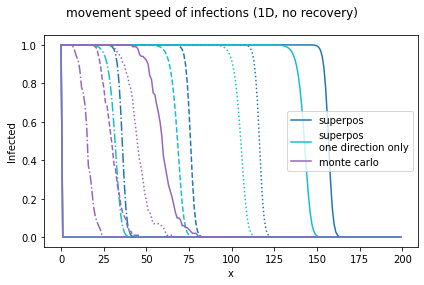

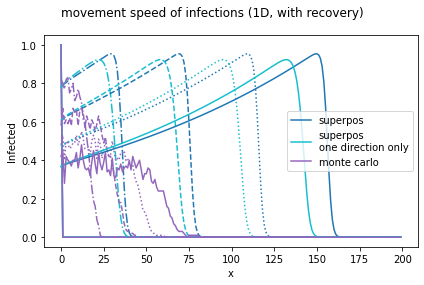

In [ ]:
# simulate and plot movement speed for a 1D chain
movement_speed_1D(beta=0.06, gamma=0, title=f'movement speed of infections (1D, no recovery)',\
    fname='figures/movement_1D_without_recovery')
movement_speed_1D(beta=0.06, gamma=0.001, title=f'movement speed of infections (1D, with recovery)',\
    fname='figures/movement_1D_with_recovery')

In [ ]:
def monte_carlo_2D(f, y0, t, params, n):
    ytn = np.zeros(shape=(*y0.shape[2:], len(t), n))
    for i in range(n):
        print('\r', i, i/n, end='')
        ytn[..., i] = f(y0, t, params)
    yt = np.average(ytn, axis=-1)  # use average for picture but plot median for time series
    print('\r' + '                ' + '\r')
    return yt, ytn

In [ ]:

def superpos_grid_sim_2D(y0, t, params, one_direction_only=False):
    beta, gamma = params
    upper = np.s_[:-1, :]  # whole grid except for the last row
    lower = np.s_[1:, :]  # everything except the first row
    left = np.s_[:, :-1]  # everything except the last column
    right = np.s_[:, 1:]  # everything except the first column

    origin = [upper, lower, left, right]  # to be iterated over
    destination = [lower, upper, right, left]  # "opposite" to origin, order must "match" origin

    if one_direction_only:
        origin = origin[::2]
        destination = destination[::2]

    yt = np.zeros(shape=(*y0.shape, len(t)))
    yt[..., 0] = y0

    for i in range(len(t)-1):
        dy = np.zeros(shape=y0.shape)
        y = yt[..., i]
        dt = t[i+1]-t[i]
        # infection transmission
        for source, target in zip(origin, destination):  # iterating over the 4 neighbor cells
            # for each element in origin and its corresponding element in destination
            nt = y[target][..., 0]
            ns = y[source][..., 1]
            dy[target][..., 1] += beta*dt * nt * ns
            dy[target][..., 0] -= beta*dt * nt * ns

        # recovery
        I = y[..., 1]  # infections
        dy[..., 1] -= gamma*dt * I  # removing infections from the infected compartment
        dy[..., 2] += gamma*dt * I  # and adding them to the recovered compartment

        yt[..., i+1] = yt[..., i] + dy
    yt_av = np.average(yt, axis=(0, 1))
    return yt_av

In [ ]:

def monte_carlo_grid_single_pass_2D(y0, t, params, one_direction_only=False):
    beta, gamma = params
    upper = np.s_[:-1, :]  # whole grid except for the last row
    lower = np.s_[1:, :]  # everything except the first row
    left = np.s_[:, :-1]  # everything except the last column
    right = np.s_[:, 1:]  # everything except the first column

    origin = [upper, lower, left, right]  # to be iterated over
    destination = [lower, upper, right, left]  # "opposite" to origin, order must "match" origin

    yt = np.zeros(shape=(*y0.shape, len(t)))
    yt[..., 0] = y0

    if one_direction_only:
        origin = origin[::2]
        destination = destination[::2]

    for i in range(len(t)-1):
        dy = np.zeros(shape=y0.shape)
        y = yt[..., i]
        dt = t[i+1]-t[i]

        # infection transmission
        for source, target in zip(origin, destination):  # iterating over the 4 neighbor cells
            # for each element in origin and its corresponding element in destination
            nt = y[target][..., 0]
            ns = y[source][..., 1]
            rnd = np.random.random(size=nt.shape)
            p = np.where(rnd < beta*dt, 1, 0)
            dy[target][..., 1] += p * nt * ns
            dy[target][..., 0] -= p * nt * ns

        # recovery
        I = y[..., 1]  # infections
        rnd = np.random.random(size=I.shape)
        p = np.where(rnd < gamma*dt, 1, 0)
        dy[..., 1] -= p * I  # removing infections from the infected compartment
        dy[..., 2] += p * I  # and adding them to the recovered compartment

        dy = np.where(dy >= 1, 1, np.where(dy <= -1, -1, 0))  # remove double infections etc.

        yt[..., i+1] = yt[..., i] + dy
    yt_av = np.average(yt, axis=(0, 1))
    return yt_av

In [ ]:

def mean_field_sim_2D(y0, t, params):
    beta, gamma = params
    N = np.prod(y0.shape[:2])  # new number of contacts
    beta = beta/(N-1)*4  # adjust beta for the new number of contacts

    yt = np.zeros(shape=(*y0.shape, len(t)))
    yt[..., 0] = y0

    for i in range(len(t) - 1):
        dy = np.zeros(shape=y0.shape)
        y = yt[..., i]
        dt = t[i + 1] - t[i]
        # infection transmission
        nt = y[..., 0]
        ns = np.sum(y[..., 1])
        dy[..., 1] += beta * dt * nt * ns
        dy[..., 0] -= beta * dt * nt * ns

        # recovery
        I = y[..., 1]  # infections
        dy[..., 1] -= gamma * dt * I  # removing infections from the infected compartment
        dy[..., 2] += gamma * dt * I  # and adding them to the recovered compartment

        yt[..., i + 1] = yt[..., i] + dy
    yt_av = np.average(yt, axis=(0, 1))
    return yt_av

In [ ]:
def analytical_mean_field(y0, t, beta, gamma, nc):
    y = np.zeros(shape=(3, len(t)))
    y[:, 0] = y0
    for i in range(len(t)-1):
        dy = np.zeros(3)
        dt = t[i+1]-t[i]
        dy[1] += y[1, i]*y[0, i]*beta*dt*nc
        dy[0] -= y[1, i]*y[0, i]*beta*dt*nc
        dy[1] -= y[1, i]*gamma*dt
        dy[2] += y[1, i]*gamma*dt
        y[:, i+1] = y[:, i] + dy
    return y

In [ ]:

def show_comparison_2D(yts, t, m, colors, labels, title, fname):
    fig = plt.figure(figsize=(15, 5))
    axes = np.array(fig.subplots(1, 3)).reshape(3, 1)
    k = [0, m, -1]

    for yt_, color, label in zip(yts, colors, labels):
        multiple = len(yt_.shape) > 2
        yt = np.average(yt_, axis=-1) if multiple else yt_
        ytn = yt_ if multiple else None

        for i in range(3):
            y = yt[i]
            if ytn is None:
                line = axes[i, 0].plot(t, y, color=color, label=label)[0]
            else:
                #y_std = np.average(std[..., i, :], axis=(0, 1))
                #y_min = np.average(ymin[..., i, :], axis=(0, 1))
                #y_max = np.average(ymax[..., i, :], axis=(0, 1))
                #axes[i, 3].fill_between(t, y-y_std, y+y_std, alpha=0.3, color=line.get_color())
                #axes[i, 3].plot(t, y_min, ':')
                #axes[i, 3].plot(t, y_max, '--')
                #ytnav = np.average(ytn, axis=(0, 1))
                y_median = np.median(ytn[i], axis=-1)
                y_av = np.average(ytn[i], axis=-1)
                axes[i, 0].plot(t, y_median, ':', linewidth=2, color=color, label=label+'\n(local median)')
                axes[i, 0].plot(t, y_av, '--', color=color, label=label+'\n(average)')
                for q in range(ytn.shape[-1]):
                    y_ = ytn[i, ..., q]
                    axes[i, 0].plot(t, y_, linewidth=0.5, alpha=0.4, color=color)
    fig.suptitle(title)
    axes[1, 0].legend(loc='upper right')
    for ax in axes.flatten():
        ax.set_xlabel('t')
    axes[0, 0].set_ylabel('Susceptible')
    axes[1, 0].set_ylabel('Infected')
    axes[2, 0].set_ylabel('Recovered')
    fig.tight_layout()
    plt.savefig(fname)
    return fig, axes

In [ ]:
def compare_SIR_models(beta, gamma, title, fname):
    
    params = (beta, gamma)

    gs = 100  # grid size
    t = np.linspace(0, 1000, 1001)  # time to use for calculation
    m = 200  # for plots
    n = 25  # number of runs for monte carlo

    d = int(gs/2-1)
    y0_grid = np.zeros(shape=(gs, gs, 3))
    y0_grid[..., 0] = 1
    y0_grid[d, d, 1] = 1
    y0_grid[d, d, 0] = 0

    yt_superpos_grid = superpos_grid_sim_2D(y0_grid, t, params)

    yt_monte_carlo_grid, ytn_monte_carlo_grid = monte_carlo_2D(monte_carlo_grid_single_pass_2D, y0_grid, t, params, n)

    yt_mean_field = mean_field_sim_2D(y0_grid, t, params)
    
    yts = [ytn_monte_carlo_grid, yt_mean_field, yt_superpos_grid]#, yt_superpos_grid_mod, ytn_monte_carlo_grid_mod]
    labels = ['monte carlo grid', 'mean field', 'superposition grid']#, 'superposition grid\none way only', 'monte carlo grid\none way only']
    colors = ['tab:purple', 'tab:green', 'tab:blue']#, 'tab:cyan', 'tab:olive']

    fig, axes = show_comparison_2D(yts, t, m, colors, labels, title, fname)


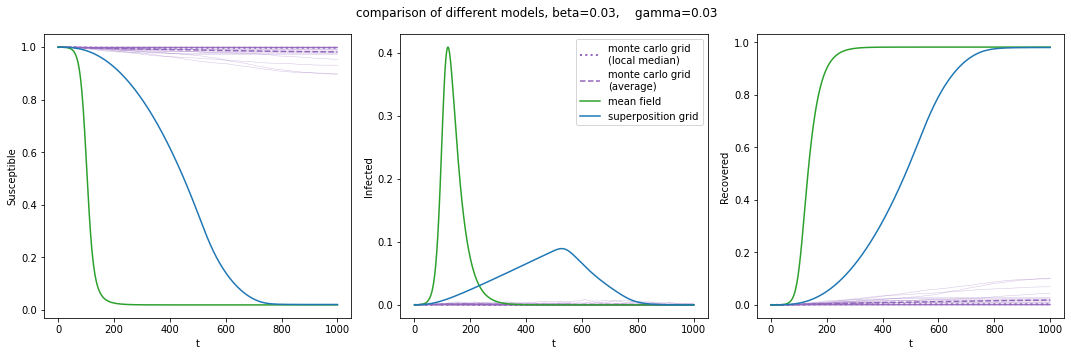

In [ ]:
beta = 0.03
gamma = 0.03
compare_SIR_models(beta=beta, gamma=gamma, title=f'comparison of different models, beta={beta},\
    gamma={gamma}', fname='figures/model_comparison_low_beta.png')



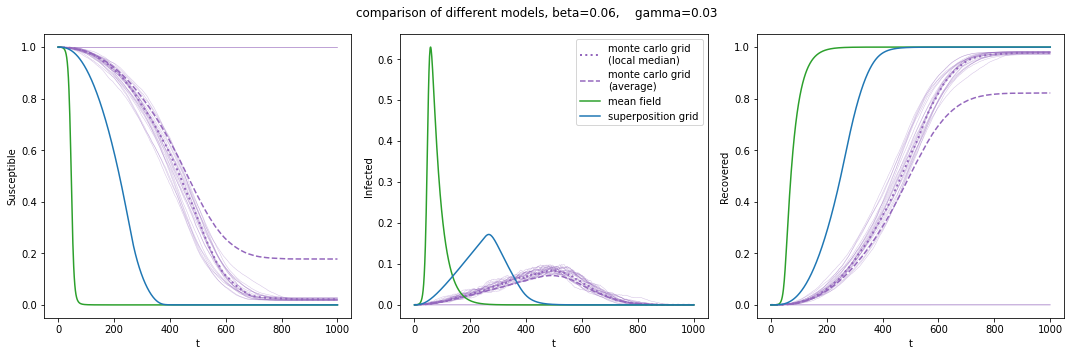

In [ ]:
beta = 0.06
gamma = 0.03
compare_SIR_models(beta=beta, gamma=gamma, title=f'comparison of different models, beta={beta},\
    gamma={gamma}', fname='figures/model_comparison_high_beta.png')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ac0f8ce2-3132-47be-a4d1-6216636e93ff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>